# ResNet 34 model for Plant Seedlings Classification #

### Imports ###

In [1]:
import os

import torch
from torch import nn
from torch import optim # Model optimizer
from torch.utils.data import Dataset, DataLoader, sampler # Data loading
from torch.autograd import Variable

import torchvision
from torchvision import transforms # Data augmentation
from torchvision.datasets.folder import ImageFolder # Dataset
from torchvision import models # Resnet34 Model

import torchtrainer # Torchtrainer is installed from https://github.com/nirvguy/torchtrainer
from torchtrainer import SupervisedTrainer # Training the model
from torchtrainer.callbacks import ModelCheckpoint, CSVLogger, ProgbarLogger # Model supervising
from torchtrainer.meters import CategoricalAccuracy # Accuracy criterion
from torchtrainer.meters.aggregators.batch import Average
from torchtrainer.meters.aggregators.scale import percentage
from torchtrainer.utils.data import CrossFoldValidation

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

from sklearn.metrics import confusion_matrix # Confusion Matrix

import pandas as pd # For test submission

from PIL import Image # Test dataset image opening

In [2]:
USE_CUDA = torch.cuda.is_available()
BATCH_SIZE = 40

## Train and Validation data loading ##

### Data Augmentation ###

Augment only the images of training dataset with random 
* Rotations
* Horizontal / vertical flips
* Changes to brightness, contrast, saturation and hue
* Grayscale conversion

In [3]:
training_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                         transforms.RandomRotation(degrees=60),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                                         transforms.RandomGrayscale(0.1),
                                         transforms.ToTensor()])

In [4]:
validation_transform = transforms.Compose([transforms.Resize((224, 224)),
                                           transforms.ToTensor()])

### Loading the training dataset ###

In [5]:
training_dataset = ImageFolder('data/train', transform=training_transform)
validation_dataset = ImageFolder('data/train', transform=validation_transform)

In [6]:
training_dataset.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [7]:
num_classes = len(training_dataset.classes)

In [8]:
assert(training_dataset.class_to_idx == validation_dataset.class_to_idx)

### Training - Validation Split ###

In [9]:
splitter = CrossFoldValidation(training_dataset, valid_dataset=validation_dataset, valid_size=0.3)

In [10]:
train_split_ds, valid_split_ds = next(iter(splitter))

### Visualizing validation and augmented training samples ###

In [11]:
from itertools import islice
from operator import itemgetter

def take_n_images(dataset, specie_idx, nr_images=10):
    images = filter(lambda x: x[1] == specie_idx, dataset)
    images = islice(images, nr_images)
    return list(map(itemgetter(0), images))

In [12]:
def plot_images(dataset, classes, nr_images=11, title=''):
    images_per_class = [take_n_images(dataset, i, nr_images) for i in range(len(classes))]
    fig = plt.figure(1, (15., 15.))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(12, 12), 
                     axes_pad=0.1,
                     )
    i = 0
    for class_idx, images in enumerate(images_per_class):
        for image in images:
            grid[i].imshow(image.permute(2,1,0).numpy())
            grid[i].set_xticks([])
            grid[i].set_yticks([])
            i += 1
        grid[i].text(0, 112, classes[class_idx])
        grid[i].set_xticks([])
        grid[i].set_yticks([])
        i += 1
    
    plt.title(title)
    plt.show()

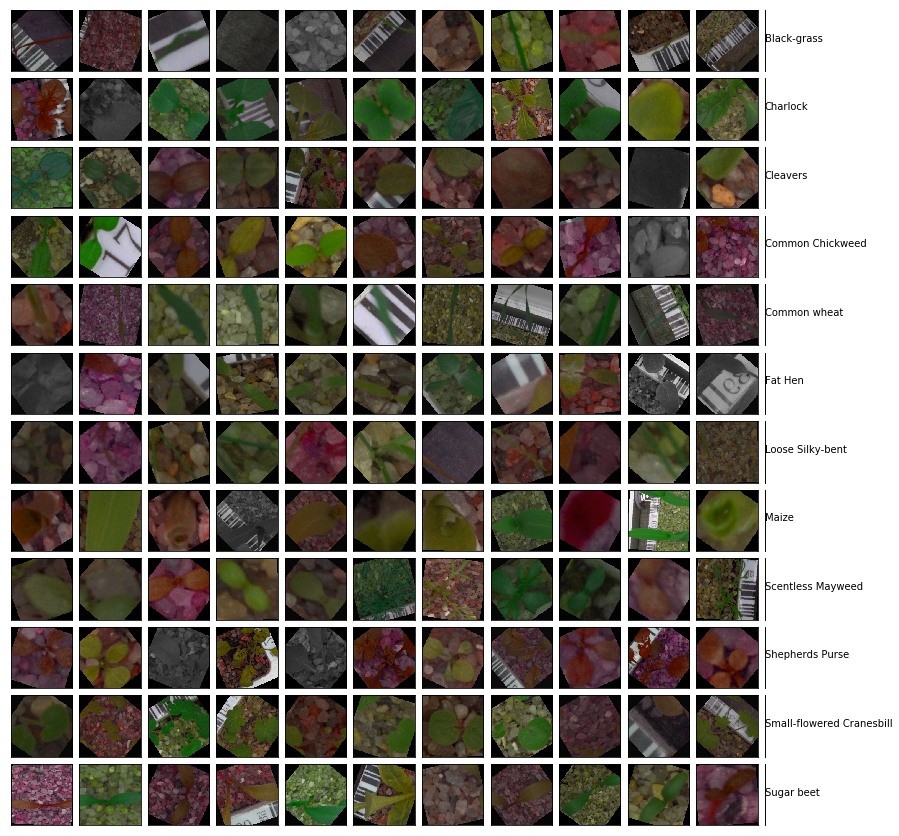

In [13]:
plot_images(train_split_ds, classes=training_dataset.classes, title='Training samples')

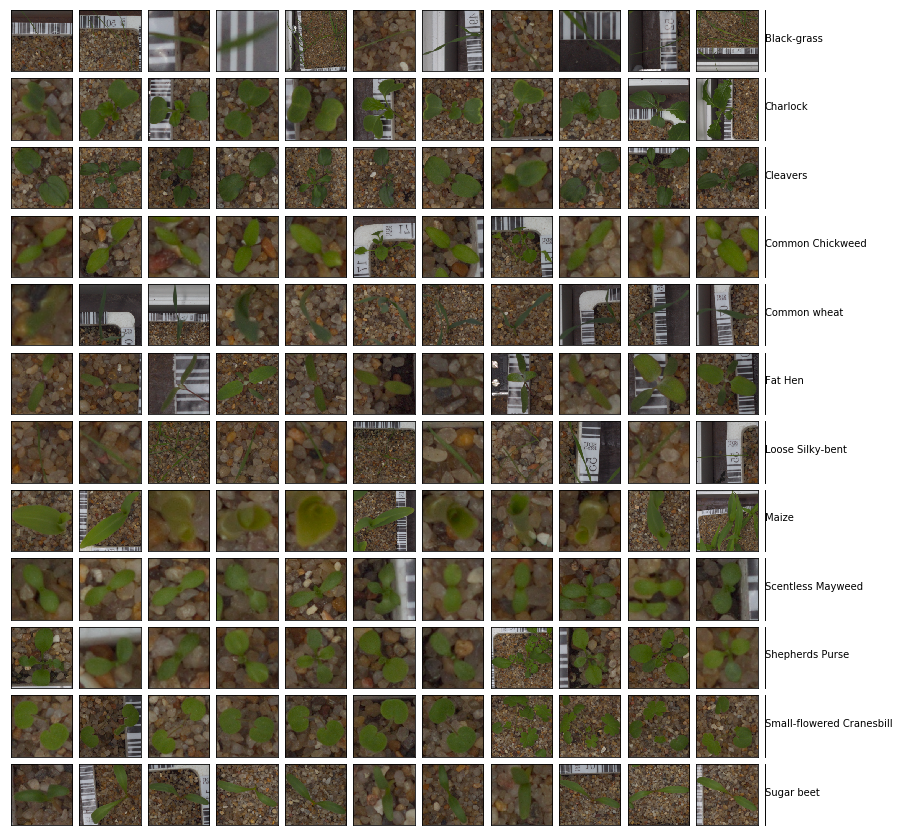

In [14]:
plot_images(valid_split_ds, classes=training_dataset.classes, title='Validation samples')

## Model Definition ##

### ResNet-34 ###

![ResNet Architecture](img/resNet.jpeg)

In [15]:
model = models.resnet34(pretrained=True)

In [16]:
model

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

For adapt `resnet34` model to plant seedlings classification it's necessary to change the last fully connected layer (of 1000 outputs) to one with 12 (one for each plant specie)

In [17]:
model.fc = nn.Linear(in_features=512, out_features=12, bias=True)

Turn the model to cuda if wanted to train on GPU

## Training Phase ##

### Optimizer & Regularizers ###

In [18]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

Regularization techniques applied are:
* L1 Regularization for convolutional layers to encourage sparsity
* L2 Regularization for the last fully connected layer
* Reduce learning rate if validation loss does not improve after 5 epochs

In [19]:
callbacks = [ModelCheckpoint(path='weights', monitor='val_loss'),
             ProgbarLogger(notebook=True),
             CSVLogger('stats.csv')]
metrics = {'acc': CategoricalAccuracy(k=1, aggregator=percentage(Average()))}

In [20]:
trainer = SupervisedTrainer(model=model,
                criterion=nn.CrossEntropyLoss(),
                optimizer=optimizer,
                callbacks=callbacks,
                logging_frecuency=10,
                acc_meters=metrics)

In [21]:
if USE_CUDA:
    trainer.cuda()

In [22]:
train_dl = DataLoader(train_split_ds, batch_size=BATCH_SIZE)
valid_dl = DataLoader(valid_split_ds, batch_size=BATCH_SIZE)

In [23]:
trainer.train(train_dl,
              valid_dataloader=valid_dl,
              epochs=20)

## Evaluation ##

Load the best scored model

In [25]:
callbacks[0].load()

{'epoch': 12, 'val_loss': 0.1991987421080984}

### Loss ###

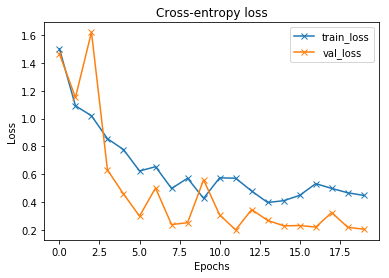

In [27]:
trainer.history.epoch_plot('train_loss')
trainer.history.epoch_plot('val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Cross-entropy loss')
plt.show()

### Accuraccy ###

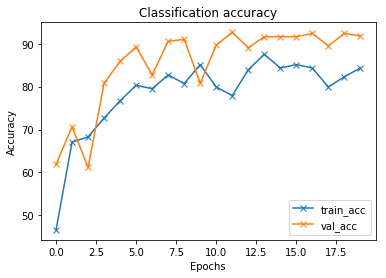

In [29]:
trainer.history.epoch_plot('train_acc')
trainer.history.epoch_plot('val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Classification accuracy')
plt.show()

### Confusion Matrix ###

From [scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) of confusion matrix. The cell $C_{i,j}$ of the confusion matrix means the number of observations known to be labeled with `i` but predicted with label `j`.

In [30]:
def predict(x):
    if USE_CUDA:
        x = x.cuda()
    x = Variable(x)
    idxs = model(x).topk(1)[1].data
    return [validation_dataset.classes[idx[0]] for idx in idxs]

In [32]:
labels = []
targets = []
for i, (tensor, target) in enumerate(valid_dl):
    p = predict(tensor)
    labels.extend(p)
    targets.extend([validation_dataset.classes[t] for t in target])
conf_matrix = confusion_matrix(targets, labels, labels=validation_dataset.classes)

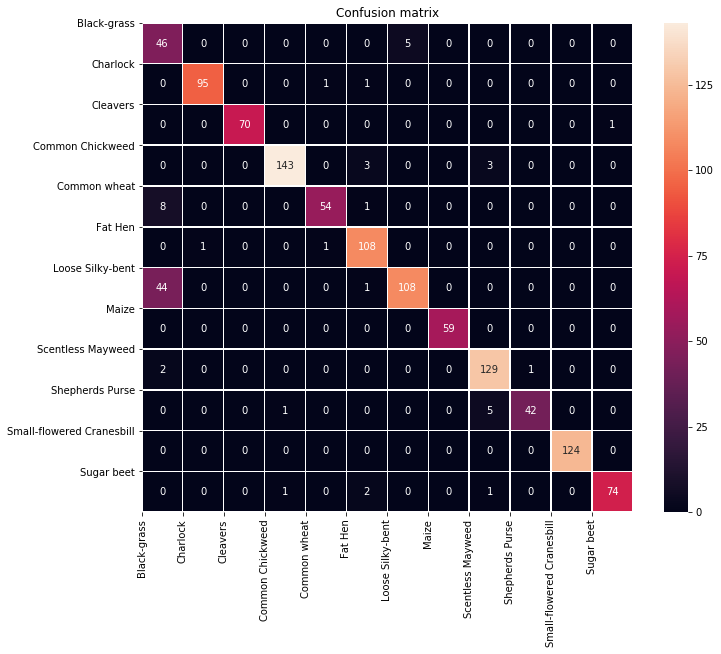

In [33]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Confusion matrix")
plt.xticks(range(num_classes), validation_dataset.classes, rotation='vertical')
plt.yticks(range(num_classes), validation_dataset.classes, rotation='horizontal')
plt.show()

## Test Submission ##

In [34]:
class TestPlantsDataset(Dataset):
    def __init__(self, root, transform=None):
        super(TestPlantsDataset, self).__init__()
        self.root = root
        self.transform = transform
        self.images_names = sorted(os.listdir(self.root))

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        image_name = self.images_names[idx]
        image = Image.open(os.path.join(self.root, image_name))
        if self.transform:
            image = self.transform(image)
        return image

In [35]:
test_dataset = TestPlantsDataset('data/test/', transform=validation_transform)

In [36]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [37]:
names = test_dataset.images_names
species = []
for x in test_loader:
    species.extend(predict(x))

df = pd.DataFrame({'file' : names, 'species' : species})

In [38]:
df

,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet
5,00d090cde.png,Black-grass
6,00ef713a8.png,Common Chickweed
7,01291174f.png,Fat Hen
8,026716f9b.png,Black-grass
9,02cfeb38d.png,Loose Silky-bent


In [39]:
df.to_csv('submission.csv', index=False)